In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2020-11-16 06:04:36--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 172.67.173.198, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7468237 (7.1M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.12M  19.2MB/s    in 0.4s    

2020-11-16 06:04:36 (19.2 MB/s) - ‘ita-eng.zip’ saved [7468237/7468237]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [ ]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2020-11-16 06:04:42--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.1, 2620:100:601c:1::a27d:601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2020-11-16 06:04:42--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9d6631bc56059ac38790570bce.dl.dropboxusercontent.com/cd/0/inline/BDQQ5RcRkiOX5gobMYNjhGmzobSoyW0SeIuvIp05mY2kI2mDCd7ShAOrMC2iMYRHe-jxrenMMB_drsgvf2HH-TnOSF0pH4cA4GQ7UhIELRc5ZYV9WhToRV6FlEP44W77m08/file# [following]
--2020-11-16 06:04:43--  https://uc9d6631bc56059ac38790570bce.dl.dropboxusercontent.com/cd/0/inline/BDQQ5RcRkiOX5gobMYNjhGmzobSoyW0SeIuvIp05mY2kI2mDCd7ShAOrMC2iMYRHe-jxrenMMB_drsgvf2HH-TnOSF0pH4cA4GQ

### <font color='blue'>**Loading data**</font>

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,Concatenate,TimeDistributed,Masking
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np

In [ ]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(341554, 2)


,english,italian
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


In [ ]:
def decontractions(phrase):
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):

    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):

    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,run,corri
2,run,corra
3,run,correte
4,who,chi


In [ ]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(ita_lengths, i))
for i in range(90,101):
    print(i,np.percentile(ita_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 9.0
97 10.0
98 11.0
99 12.0
100 92.0
99.1 12.0
99.2 12.0
99.3 12.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 20.0
100 92.0


In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(eng_lengths, i))
for i in range(90,101):
    print(i,np.percentile(eng_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

0 1.0
10 4.0
20 4.0
30 5.0
40 5.0
50 6.0
60 6.0
70 7.0
80 7.0
90 8.0
100 101.0
90 8.0
91 9.0
92 9.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 101.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 20.0
100 101.0


> <font color="blue"><b>If you observe the values, 99.9% of the data points are having length &lt; 20, so select the sentences that have words &lt; 20 </b> </font>
<br>
<br>
> <font color="green"><b>Inorder to do the teacher forcing while training of seq-seq models, lets create two new columns, one with  &lt;start&gt; token at begining of the sentence and other column with &lt;end&gt; token at the end of the sequence</b></font>

In [ ]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,corri,<start> run,run <end>
2,corra,<start> run,run <end>
3,correte,<start> run,run <end>
4,chi,<start> who,who <end>


In [ ]:
data.sample(10)

,italian,english_inp,english_out
83958,vi piacciono i broccoli,<start> do you like broccoli,do you like broccoli <end>
31757,tu puoi tornare indietro,<start> you can go back,you can go back <end>
103074,non pagherò questa bolletta,<start> i will not pay this bill,i will not pay this bill <end>
41157,tom vi pagherà,<start> tom will pay you,tom will pay you <end>
304533,lo sapevo che volevi dirmi qualcosa,<start> i knew you wanted to tell me something,i knew you wanted to tell me something <end>
300175,guardate il treno che attraversa il ponte,<start> look at the train crossing the bridge,look at the train crossing the bridge <end>
176770,non ricordo molto,<start> i do not remember very much,i do not remember very much <end>
216883,tom dove ha imparato tutto questo,<start> where did tom learn all this,where did tom learn all this <end>
319046,zezo non è il mio nome è solo un soprannome,<start> zezo is not my name it is only a nickname,zezo is not my name it is only a nickname <end>
297036,non hai il permesso di farlo,<start> you do not have permission to do that,you do not have permission to do that <end>


In [ ]:
data.shape

(341166, 3)

### Getting train and test 

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [ ]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(272932, 3) (68234, 3)


In [ ]:
train.head()

,italian,english_inp,english_out
71577,comè stata la tua estate,<start> how was your summer <end>,how was your summer <end> <end>
164618,io parlerò con tom,<start> i am going to speak to tom,i am going to speak to tom <end>
249319,vorrei aver comprato un vestito bianco,<start> i wish i would bought a white dress,i wish i would bought a white dress <end>
157644,non cambia mai vero,<start> you never change do you,you never change do you <end>
283371,perché hai starnutito per tutto il giorno,<start> why have you been sneezing all day,why have you been sneezing all day <end>


In [ ]:
validation.head()

,italian,english_inp,english_out
104819,guarda letichetta del prezzo,<start> look at the price tag,look at the price tag <end>
47778,io sono stato discreditato,<start> i was discredited,i was discredited <end>
180291,non è troppo lontano da qui,<start> it is not too far from here,it is not too far from here <end>
134407,è sicuro entrare adesso,<start> is it safe to enter now,is it safe to enter now <end>
229048,tom fu arrestato quella sera,<start> tom was arrested that evening,tom was arrested that evening <end>


In [ ]:

import seaborn as sns

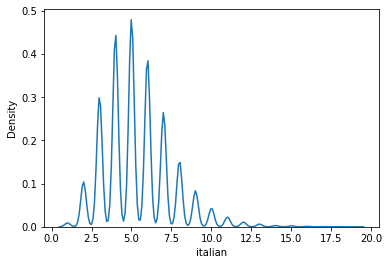

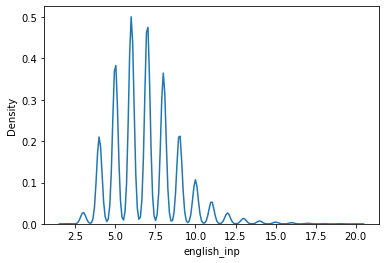

In [ ]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

### Creating Tokenizer on the train data and learning vocabulary

> Note that we are fitting the tokenizer only on train data and check the filters for english, we need to remove symbols &lt; and &gt;

In [ ]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [ ]:
len(tknizer_eng.word_index.keys())

12776

In [ ]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

12776
26089


In [ ]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10060)

In [ ]:
data.shape

(341166, 3)

In [ ]:
def grader_1(data):
    shape_value = data.shape ==(340044, 3)
    tknizer = Tokenizer(char_level=True)
    tknizer.fit_on_texts(data['italian'].values)
    ita_chars = tknizer.word_index.keys()
    diff_chars_ita = set(ita_chars)-set([' ', 't', 'a', 'o', 'r', 'e', 's', 'i', 'n', 'l', 'c', 'm', 'u', 'd', 'p', 'v', 'h', 'g', 'b', 'f', 'è', 'q', 'z', 'ò', 'à', 'y', 'é', 'ì', 'ù', 'k', 'w', '0', 'j', '1', '3', '2', 'x', '9', '5', '8', '4', '6', '7', 'á', 'ñ', 'ê', 'ü', 'ō', 'î', 'ö', 'ú', 'º'])
    tknizer = Tokenizer(char_level=True)
    tknizer.fit_on_texts(data['english_inp'].values)
    eng_chars = tknizer.word_index.keys()
    diff_chars_eng = set(eng_chars)-set(['<','>',' ', 'e', 'o', 't', 'i', 'a', 'n', 's', 'h', 'r', 'l', 'd', 'm', 'y', 'u', 'w', 'g', 'c', 'p', 'f', 'b', 'k', 'v', 'j', 'x', 'z', 'q', '0', '1', '3', '2', '9', '5', '8', '6', '4', '7'])
    unique_char_value = (len(diff_chars_eng)==0) and (len(diff_chars_ita)==0)
    return unique_char_value and shape_value

grader_1(data)

False

### Creating embeddings for english sentences

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.inp_vocab_size=inp_vocab_size
        self.embedding_size=embedding_size
        self.lstm_size=lstm_size
        self.input_length=input_length
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.inp_vocab_size, output_dim=self.embedding_size, input_length=self.input_length, name="embedding_layer_encoder")
        self.masking=Masking(mask_value=0)
        self.lstm = LSTM(self.lstm_size, return_state=True, name="Encoder_LSTM")
    def call(self,input_sequence,training=True):
        input_embedd = self.embedding(input_sequence)
        input_embedd=self.masking(input_embedd)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c
        
    def get_states(self):
        return self.lstm_state_h,self.lstm_state_c

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.out_vocab_size=out_vocab_size
        self.embedding_size=embedding_size
        self.lstm_size=lstm_size
        self.input_length=input_length
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.out_vocab_size, output_dim=self.embedding_size, input_length=None,
                           name="embedding_layer_decoder",weights=[embedding_matrix], trainable=False)
        self.masking=Masking(mask_value=0)
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Decoder_LSTM")
    def call(self,target_sentances,state_h,state_c):
        #print("DECODER ==> IN PUT SQUENCES SHAPE :",target_sentances.shape)
        target_embedd           = self.embedding(target_sentances)
        target_embedd=self.masking(target_embedd)
        #print("WE ARE INITIALIZING DECODER WITH ENCODER STATES :",state_h.shape, state_c.shape)
        lstm_output,dec_h,dec_c       = self.lstm(target_embedd, initial_state=[state_h, state_c])
        return lstm_output,dec_h,dec_c

In [ ]:
class Encoder_decoder(tf.keras.Model):
    def __init__(self,encoder_input_length,decoder_input_length,output_vocabsize):
        super().__init__()
        self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1,embedding_size=100,input_length=encoder_input_length, lstm_size=256)
        self.decoder = Decoder(out_vocab_size=vocab_size_eng+1, embedding_size=100, input_length=decoder_input_length, lstm_size=256)
        self.dense   = TimeDistributed(Dense(units=output_vocabsize+1,activation="softmax")    )
    def call(self, data):
        input,output = data[0], data[1]
        #print("="*20, "ENCODER", "="*20)
        encoder_output, encoder_h, encoder_c = self.encoder(input)
        decoder_output                       = self.decoder(output, encoder_h, encoder_c)[0]
        output                               = self.dense(decoder_output)
        return output    

In [ ]:
embedding_matrix.shape

(12777, 100)

In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(data, tknizer_ita, tknizer_eng, 20)

test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
vocab_size_eng

12776

### Callbacks


In [ ]:
#earlystopping
import numpy as np


class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=3):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        #self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get("loss")
        current_valloss = logs.get("val_loss")
        if np.less(current_valloss,current_loss):
            #self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))




In [ ]:
model  = Encoder_decoder(encoder_input_length=20,decoder_input_length=None,output_vocabsize=vocab_size_eng)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//10210
valid_steps=validation.shape[0]//1024
history=model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=500, validation_data=test_dataloader, validation_steps=valid_steps,verbose=1)
model.summary()

Epoch 1/500
26/26 [==============================] - 25s 978ms/step - loss: 1.9092 - val_loss: 1.6525
Epoch 2/500
26/26 [==============================] - 23s 896ms/step - loss: 1.3779 - val_loss: 1.6272
Epoch 3/500
26/26 [==============================] - 23s 885ms/step - loss: 1.4408 - val_loss: 1.6047
Epoch 4/500
26/26 [==============================] - 23s 887ms/step - loss: 1.6113 - val_loss: 1.5855
Epoch 5/500
26/26 [==============================] - 23s 892ms/step - loss: 1.4992 - val_loss: 1.5936
Epoch 6/500
26/26 [==============================] - 23s 892ms/step - loss: 1.6057 - val_loss: 1.5631
Epoch 7/500
26/26 [==============================] - 23s 891ms/step - loss: 1.5797 - val_loss: 1.5600
Epoch 8/500
26/26 [==============================] - 23s 890ms/step - loss: 1.6742 - val_loss: 1.5388
Epoch 9/500
26/26 [==============================] - 23s 897ms/step - loss: 1.4862 - val_loss: 1.5362
Epoch 10/500
26/26 [==============================] - 23s 889ms/step - loss: 1.557

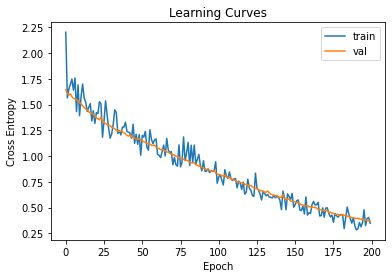

In [ ]:
'''import matplotlib.pyplot as plt
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
'''

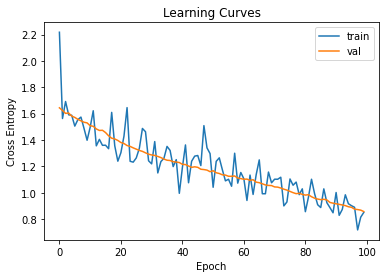

In [ ]:
"""
import matplotlib.pyplot as plt
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
"""

In [ ]:

def predic_fun(input_sentence):
    input_pred=[tknizer_ita.word_index[i] for i in input_sentence.split()] 
    print("input tokens",input_pred)
    a,b,c=model.layers[0](np.expand_dims(input_pred, 0))
    state_values=[b,c]
    start="<start>"
    pred=[]
    for i in range(0,20):
        start=tknizer_eng.word_index[start] 
        cur_vec = np.array(start).reshape(1,1)
        cur_emb=model.layers[1].embedding(cur_vec)
        infe_output, state_h, state_c = model.layers[1].lstm(cur_emb, initial_state=state_values)
        state_values=[state_h, state_c]
        infe_output=model.layers[2](infe_output)
        ind=np.argmax(infe_output)
        start=tknizer_eng.index_word[ind]
        print("new eng word",start)
        pred.append(tknizer_eng.index_word[ind])
        if start=="<end>":
            break
    return pred

In [ ]:
model.layers

In [ ]:
predic_fun("corra")

input tokens [6300]
new eng word tonguetied
new eng word teaspoons
new eng word specialty
new eng word niagara
new eng word showroom
new eng word tonguetied
new eng word quotations
new eng word rid
new eng word tom
new eng word almost
new eng word there
new eng word the
new eng word best
new eng word <end>


['tonguetied',
 'teaspoons',
 'specialty',
 'niagara',
 'showroom',
 'tonguetied',
 'quotations',
 'rid',
 'tom',
 'almost',
 'there',
 'the',
 'best',
 '<end>']

In [ ]:
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,corri,<start> run,run <end>
2,corra,<start> run,run <end>
3,correte,<start> run,run <end>
4,chi,<start> who,who <end>


In [ ]:
start="<start>"
start=tknizer_eng.word_index[start] 

print(cur_vec)
cur_emb=model.layers[1].embedding(cur_vec)
infe_output, state_h, state_c = model.layers[1].lstm(cur_emb, initial_state=state_values)

[[1]]


In [ ]:
(model.layers[2](infe_output))

<tf.Tensor: shape=(1, 1, 12824), dtype=float32, numpy=
array([[[4.4696963e-06, 4.8093671e-06, 3.4546074e-02, ...,
         5.9254130e-06, 5.9093695e-06, 6.6285579e-06]]], dtype=float32)>